In [ ]:
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
!pip install dask[dataframe]

In [ ]:
# Load the model using pickle

output_path = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict/trained_model/trained_model.pkl"
with open(output_path, "rb") as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully")

output_path = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict/trained_model/xg_trained_model.pkl"
with open(output_path, "rb") as file:
    xg_loaded_model = pickle.load(file)

print("Model loaded successfully")

Model loaded successfully
Model loaded successfully


In [ ]:
#Load the optimal parameters and features found in model training
output_path = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict/trained_model/model_metadata.pkl"
with open(output_path, "rb") as pkl_file:
    data = pickle.load(pkl_file)

imp_features = data["imp_features"]
best_params = data["best_params"]

xgb_params = {
    'learning_rate': 0.05,
    'max_depth': 5,
    'objective': 'reg:squarederror',
    'n_estimators': 1000,  # Can be adjusted
    'min_child_weight': 50,  # Similar to min_data_in_leaf
    'colsample_bytree': 1.0,
    'subsample': 1.0,
    'verbosity': 0,
}


print(imp_features)
print(best_params)

['solarradiation_mean_lag5_sh-2', 'month', 'temp_mean_lag24_sh1', 'solarradiation_gradient_lag1', 'weekday', 'weekday_hour', 'solarradiation', 'hour', 'temp_max_lag3_sh1', 'temp_gradient_lag1', 'windspeed_mean_lag3_sh1', 'cloudcover_mean_lag3_sh1', 'temp_mean_lag3_sh24']
{'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_data_in_leaf': 50, 'num_leaves': 20, 'verbosity': -1}


In [ ]:
output_path = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict/processed_data/processed_test_set.pkl"

with open(output_path, "rb") as file:
    test_df = pickle.load(file)

print("Test set loaded successfully")

Test set loaded successfully


In [ ]:
#Now drop features from the testing set, only keeping omptimal features
target = "usage_kWh"
X_test = test_df[imp_features]
y_test = test_df[target]

In [ ]:
def rmsle(y_true, y_pred):
  # Good article on RMSLE: https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a
  y_pred = np.clip(y_pred, 0, None) #Any value in y_pred that is less than 0 will be replaced with 0
  return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [ ]:
# Generate predictions from both models
y_lgbm = loaded_model.predict(X_test)
xgb_y_pred = xg_loaded_model.predict(X_test)

# Align predictions by trimming to the smallest array size
min_len = min(len(y_lgbm), len(xgb_y_pred))
y_lgbm, xgb_y_pred = y_lgbm[:min_len], xgb_y_pred[:min_len]

# Calculate the ensemble prediction
y_pred = (y_lgbm + xgb_y_pred)/2

# Check for invalid values in y_test and y_pred
print("NaN in y_test:", np.isnan(y_test[:min_len]).sum())
print("NaN in y_pred:", np.isnan(y_pred).sum())
print("Negative values in y_test:", (y_test[:min_len] < 0).sum())
print("Negative values in y_pred:", (y_pred < 0).sum())

# Remove invalid values
valid_mask = ~np.isnan(y_test[:min_len]) & ~np.isnan(y_pred) & (y_test[:min_len] >= 0) & (y_pred >= 0)
y_test, y_pred = y_test[:min_len][valid_mask], y_pred[valid_mask]

# Calculate RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

score = rmsle(y_test, y_pred)
print("The root mean squared percentage error of the model is:", round(score, 3))

# Calculate MAPE
def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Avoid division by zero
    y_true, y_pred = y_true[non_zero_mask], y_pred[non_zero_mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = mape(y_test, y_pred)
print("The MAPE of the model is:", round(score, 3))


NaN in y_test: 0
NaN in y_pred: 0
Negative values in y_test: 2
Negative values in y_pred: 0
The root mean squared percentage error of the model is: 0.286
The MAPE of the model is: 12.752


In [ ]:
results = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})

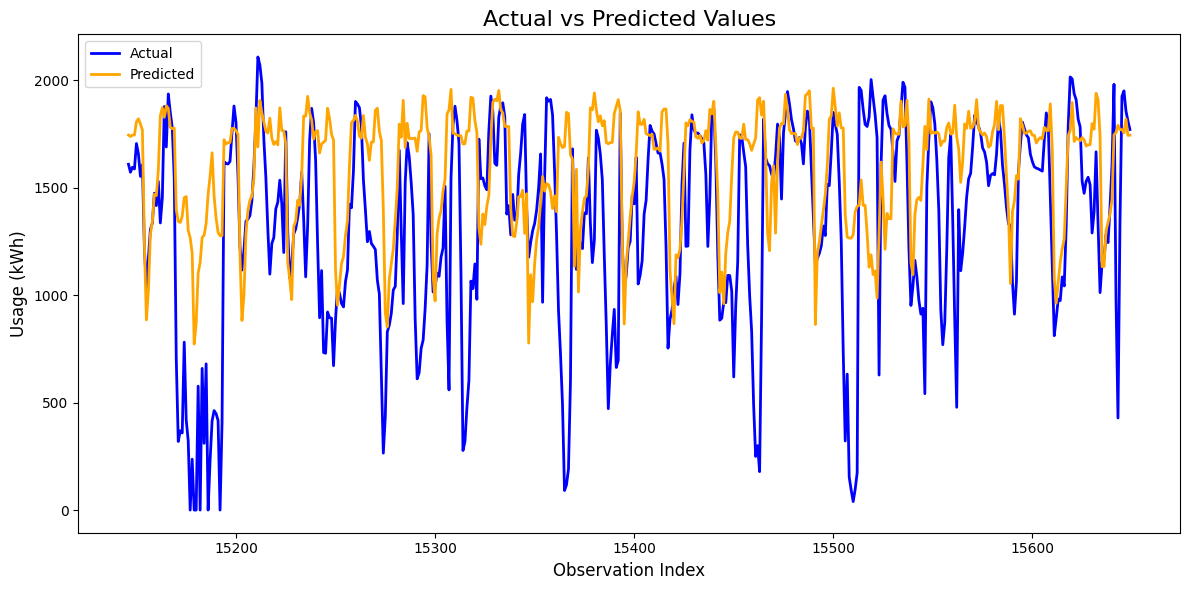

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))
days = 21
# plt.plot(results.index, results['Actual'], label='Actual', color='blue', linewidth=2)
# plt.plot(results.index, results['Predicted'], label='Predicted', color='orange', linewidth=2)
plt.plot(results.index[:days*24], results['Actual'][:days*24], label='Actual', color='blue', linewidth=2)
plt.plot(results.index[:days*24], results['Predicted'][:days*24], label='Predicted', color='orange', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel('Usage (kWh)', fontsize=12)

# Adding legend and grid for better readability
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
plt.savefig("energy_prediction_plot.png")

In [ ]:
predicted_kWh = round(np.sum(y_pred),2)
actual_kWh = round(np.sum(y_test),2)

print(f"Predicted kWh: {predicted_kWh}")
print(f"Actual kWh: {actual_kWh}")

round((actual_kWh-predicted_kWh)/actual_kWh,3)

Predicted kWh: 63952.44
Actual kWh: 58610.56


np.float64(-0.091)